# Mcculloch-Pitts Neuron

## Introduction
Mcculloch-Pitts Neuron is a simple model of a neuron. It takes a set of binary inputs and produces a binary output. The output is 1 if the weighted sum of the inputs is greater than a threshold value, and 0 otherwise. The model is named after Warren McCulloch and Walter Pitts, who introduced it in 1943. The model is also known as a threshold logic unit.  

In this network all inputs and outputs are binary. The inputs are either 0 or 1, and the output is either 0 or 1. 

We try to model a 4-bit, 2's complement circuit using Mcculloch-Pitts Neuron, the circuit is as follows:  

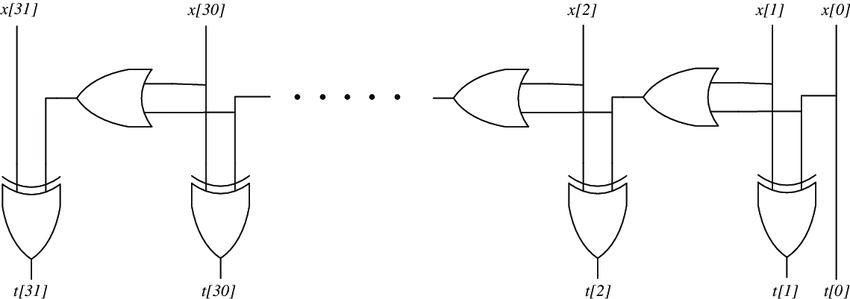

In [26]:
import numpy as np
import pandas as pd

from typing import Callable

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix
from torch import nn, optim, tensor, all, float32, where, flip
from torch.nn import functional as F
from torch.utils.data import DataLoader, TensorDataset

## Creating the dataset

We will create a dataset of 4-bit numbers and their 2's complement. The 2's complement of a number is obtained by inverting all the bits of the number and adding 1 to the least significant bit.

In [27]:
class TwosComplementDataset:
    def __init__(
        self, 
        n_samples: int = 1000, 
        n_bits: int = 4, 
        transform: Callable = None
    ):
        self._n_samples = n_samples
        self._n_bits = n_bits
        self._transform = transform
        self._generate_data()

    def _generate_data(self):
        self._x = np.array([np.random.randint(0, 2, self._n_bits) for _ in range(self._n_samples)])
        self._y = self._twos_complement(self._x)

        self._x = tensor(self._x, requires_grad=False, dtype=float32)
        self._y = tensor(self._y, requires_grad=False, dtype=float32)

    def _twos_complement(self, x: np.ndarray[np.ndarray[int]]) -> np.ndarray[int]:
        return np.array([self._twos_complement_single(x_i) for x_i in x])

    def _twos_complement_single(self, x: np.ndarray[int]) -> np.ndarray[int]:
        # if x[0] == 0: # real twos complement 
        #     return x
        if np.all(x == 0):
            return x
        last_one_idx = np.where(x == 1)[0][-1]
        x = np.copy(x)
        x[:last_one_idx] = 1 - x[:last_one_idx]
        return x

    def __len__(self):
        return self._n_samples

    def __getitem__(self, idx):
        x = self._x[idx]
        y = self._y[idx]

        if self._transform:
            x, y = self._transform(x, y)

        return x, y

    def get_data(self):
        return self._x, self._y

    def get_dataloader(self, batch_size: int = 32):
        return DataLoader(
            TensorDataset(self._x, self._y), batch_size=self._n_samples, shuffle=True
        )
        
    def show_samples(self, n_samples: int = 5):
        x, y = self.get_data()
        for i in np.random.choice(range(len(x)), n_samples):
            print(f"x: {x[i].numpy()}, y: {y[i].numpy()}")

In [28]:
dataset = TwosComplementDataset(n_samples=1000, n_bits=4)

In [29]:
dataset.show_samples()

x: [0. 0. 1. 0.], y: [1. 1. 1. 0.]
x: [0. 1. 0. 0.], y: [1. 1. 0. 0.]
x: [1. 0. 0. 0.], y: [1. 0. 0. 0.]
x: [0. 0. 0. 1.], y: [1. 1. 1. 1.]
x: [0. 0. 0. 1.], y: [1. 1. 1. 1.]


## Model

The model consists of simple Mcculloch-Pitts Neurons. The model is trained using the dataset created above. The model is trained to predict the 2's complement of a 4-bit number.  

The artificial neuron is defined as follows:

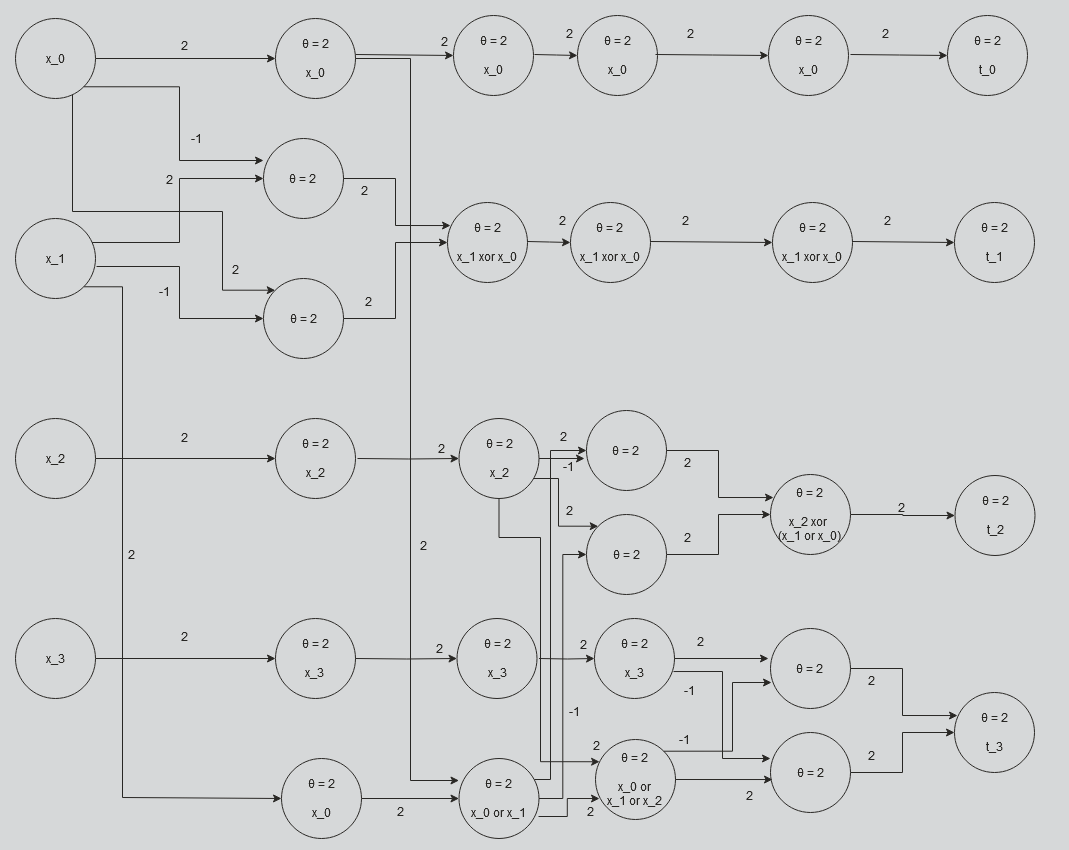

In [30]:
class TwosComplementModel(nn.Module):
    def __init__(self, n_bits: int = 4, debug: bool = False):
        super(TwosComplementModel, self).__init__()
        self._n_bits = n_bits
        self._debug = debug
        
        self._threshold = 1.5 # Don't fucking touch this line, i hate pytorch

        # 4 -> 6 -> 5 -> 6 -> 5 -> 4

        # ------------- Layer 1 -------------
        self.layer_1 = nn.Linear(n_bits, 6)
        self.layer_1.weight = nn.Parameter(
            tensor(
                [
                    [2, 0, 0, 0],
                    [-1, 2, 0, 0],
                    [2, -1, 0, 0],
                    [0, 0, 2, 0],
                    [0, 0, 0, 2],
                    [0, 2, 0, 0],
                ], dtype=float32
            )
        )
        # ----------------------------------

        # ------------- Layer 2 -------------
        self.layer_2 = nn.Linear(6, 5)
        self.layer_2.weight = nn.Parameter(
            tensor(
                [
                    [2, 0, 0, 0, 0, 0],
                    [0, 2, 2, 0, 0, 0],
                    [0, 0, 0, 2, 0, 0],
                    [0, 0, 0, 0, 2, 0],
                    [2, 0, 0, 0, 0, 2],
                ], dtype=float32
            )
        )
        # ----------------------------------
        
        
        # ------------- Layer 3 -------------
        self.layer_3 = nn.Linear(5, 6)
        self.layer_3.weight = nn.Parameter(
            tensor(
                [
                    [2, 0, 0, 0, 0],
                    [0, 2, 0, 0, 0],
                    [0, 0, -1, 0, 2],
                    [0, 0, 2, 0, -1],
                    [0, 0, 0, 2, 0],
                    [0, 0, 2, 0, 2],
                ], dtype=float32
            )
        )
        # ----------------------------------
        
        # ------------- Layer 4 -------------
        self.layer_4 = nn.Linear(6, 5)
        self.layer_4.weight = nn.Parameter(
            tensor(
                [
                    [2, 0, 0, 0, 0, 0],
                    [0, 2, 0, 0, 0, 0],
                    [0, 0, 2, 2, 0, 0],
                    [0, 0, 0, 0, 2, -1],
                    [0, 0, 0, 0, -1, 2],
                ], dtype=float32
            )
        )
        # ----------------------------------
        
        # ------------- Layer 5 -------------
        self.layer_5 = nn.Linear(5, n_bits)
        self.layer_5.weight = nn.Parameter(
            tensor(
                [
                    [2, 0, 0, 0, 0],
                    [0, 2, 0, 0, 0],
                    [0, 0, 2, 0, 0],
                    [0, 0, 0, 2, 2],
                ], dtype=float32
            )
        )
        # ----------------------------------
        
        self._layers = [self.layer_1, self.layer_2, self.layer_3, self.layer_4, self.layer_5]
        
    def _apply_threshold(self, x: tensor) -> tensor:
        return where(x >= self._threshold, tensor(1.0), tensor(0.0))

    def forward(self, x: tensor) -> tensor:
        for i, layer in enumerate(self._layers):
            if self._debug:
                print(f"Layer {i+1}: {x}") 
            x = F.relu(layer(x))
            x = self._apply_threshold(x)
        return x

In [31]:
twos_complement_model = TwosComplementModel(n_bits=4, debug=False)

## Evaluation

The model is evaluated on the test dataset. The accuracy of the model is calculated.

In [32]:
def evaluate_model(
    model: nn.Module, 
    dataloader: DataLoader, 
    show_wrong: bool = False
) -> float:
    
    model.eval()
    correct = 0
    total = 0
    for x, y in dataloader:
        for x_i, y_i in zip(x, y):
            y_pred = model(flip(x_i, [0])) # flip the input cause the model is trained on reverse order of bits
            y_pred = flip(y_pred, [0]) # flip the output back to the original order
            if all(y_pred == y_i):
                correct += 1
            elif show_wrong:
                    print(f"x: {x_i.numpy()}, y: {y_i.numpy()}, y_pred: {y_pred.numpy()}")
            total += 1

    return correct / total

In [33]:
print(f"Accuracy: {evaluate_model(twos_complement_model, dataset.get_dataloader(), show_wrong=True) * 100:.2f}%")

Accuracy: 100.00%


As can be seen from the model, the model is very simple and has a very high accuracy. The model is able to predict the 2's complement of a 4-bit number with 100% accuracy.